In [ ]:
# default_exp combine

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#hide
# stellt sicher, dass beim verändern der core library diese wieder neu geladen wird
%load_ext autoreload
%autoreload 2

# Combine

## Basic Settings

In [ ]:
# imports
from bfh_mt_hs2020_sec_data.core import * 
from pathlib import Path
from typing import List, Tuple, Union, Set

import pandas as pd

import shutil          # provides high level file operations
import time            # used to measure execution time
import os
import sys

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [ ]:
all_data_local_folder = "./data/"

join_group = ["cik","ticker","adsh","period","filed","form","fp"]
analyze_cols = ['value_count','null_count']

## 00_Tools

In [ ]:
def check_number_of_reports(df: pd.DataFrame):
    """
    check if there is only one entry per report (unique adsh)
    """
    print("is there just one report per ADSH: ", len(df.adsh.unique()) == df.shape[0])

In [ ]:
def load_data(stmt:str) -> pd.DataFrame:
    df = pd.read_csv(all_data_local_folder + stmt + "_completed.csv")

    df.period = pd.to_datetime(df.period)
    df.filed = pd.to_datetime(df.filed)

    df = df.rename(columns={'qtrs':stmt + '_qtrs'})
    
    return df

In [ ]:
def count_null(df: pd.DataFrame):
    columns = list(df.columns)
    value_cols = set(columns) -  set(join_group)
    value_cols = value_cols -  set(['bs_qtrs','is_qtrs','cf_qtrs'])
    
    df['value_count'] = df[value_cols].notnull().sum(axis=1)
    df['null_count'] = df[value_cols].isnull().sum(axis=1)
    
    print("lines with missing values: ", df[df.null_count > 0].shape[0])

In [ ]:
def print_stats(df: pd.DataFrame):
    print('number of reports:   ', df.shape[0])
    print('number of companies: ', len(df.cik.unique()))

## 01_Load data

In [ ]:
bs_df = load_data("bs")
cf_df = load_data("cf")
is_df = load_data("is")
print("bs: ", bs_df.shape)
print("cf: ", cf_df.shape)
print("is: ", is_df.shape)

bs:  (116519, 16)
cf:  (116187, 16)
is:  (115899, 14)


### drop columns

In [ ]:
is_df = is_df.drop(columns=['SharesOutstanding_hj','EarningsPerShare_hj'])

### column names simplifications

In [ ]:
bs_df = bs_df.rename(columns={'RetainedEarningsAccumulatedDeficit':'RetainedEarnings_hj'})
cf_df = cf_df.rename(columns={'NetCashProvidedByUsedInOperatingActivities':'CashFromOperating',
                              'NetCashProvidedByUsedInInvestingActivities':'CashFromInvesting',
                              'NetCashProvidedByUsedInFinancingActivities':'CashFromFinancing'})

## 02_Join data

In [ ]:
joined_df = pd.merge(bs_df, cf_df, how='outer', on=join_group)
joined_df = pd.merge(joined_df, is_df, how='outer', on=join_group)

In [ ]:
joined_df.shape

(116632, 30)

## 03_Check data_

In [ ]:
# checkdata -> every adsh should only appear once
check_number_of_reports(joined_df)

is there just one report per ADSH:  True


In [ ]:
count_null(joined_df)

lines with missing values:  1727


<AxesSubplot:>

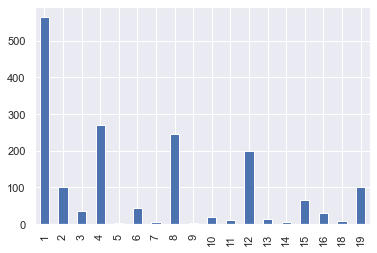

In [ ]:
# plot count of missing values. y-axis shows the number of reports, x-axis shows how many values are missing
joined_df.null_count.value_counts().sort_index()[1:].plot.bar()

In [ ]:
print("companies with just one incomplete report: ", len(set(joined_df[joined_df.null_count == 1].cik.unique()) - set(joined_df[joined_df.null_count > 1].cik.unique())))

companies with just one incomplete report:  120


<AxesSubplot:>

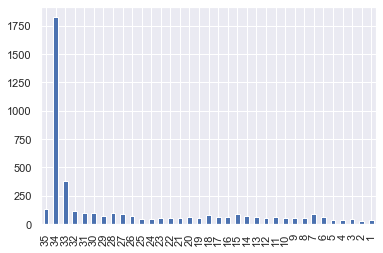

In [ ]:
# plount count of available reports: y-axis shows the number of companies, x-axis shows number of reports available
joined_df.cik.value_counts().value_counts().sort_index(ascending=False).plot.bar()

## 04_Remove Companies with missing data

In [ ]:
joined_cleaned_df = joined_df.copy()
print_stats(joined_cleaned_df)

number of reports:    116632
number of companies:  4356


### only consider companies with at least 4 years of data

In [ ]:
filtered = joined_cleaned_df.cik.value_counts()>15
ciks_with_4yrplus = filtered[filtered].index.tolist()
len(ciks_with_4yrplus)

3533

In [ ]:
joined_cleaned_df = joined_cleaned_df[joined_cleaned_df.cik.isin(ciks_with_4yrplus)]

In [ ]:
print_stats(joined_cleaned_df)

number of reports:    109147
number of companies:  3533


### remove ciks who have reports with missing values

In [ ]:
incomplete_ciks = joined_cleaned_df[joined_cleaned_df.null_count > 0].cik.unique()
print(len(incomplete_ciks))

473


In [ ]:
joined_cleaned_df = joined_cleaned_df[~joined_cleaned_df.cik.isin(incomplete_ciks)]

In [ ]:
print_stats(joined_cleaned_df)

number of reports:    94819
number of companies:  3060


### other cleaning that could/should be done

- either ensure that the first entry for a cik is a yearly report or ensure that it is quarter 1
- ensure that there are no reports missing
- since there many reports with just a single value missing

## 05_Save

In [ ]:
joined_cleaned_df.drop(columns = analyze_cols).to_csv(all_data_local_folder + "complete.csv", index=False)